In [1]:
import sys
sys.path1 = [x for x in sys.path if "besca2_2" in x]
sys.path2 = [x for x in sys.path if "besca2_2" not in x]
sys.path = sys.path1 + sys.path2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Standard-BESCA-workflow" data-toc-modified-id="Standard-BESCA-workflow-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Standard BESCA workflow</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Import-section" data-toc-modified-id="Import-section-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Import section</a></span></li></ul></li><li><span><a href="#Setup-Standard-Wokflow" data-toc-modified-id="Setup-Standard-Wokflow-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup Standard Wokflow</a></span><ul class="toc-item"><li><span><a href="#Parameters-to-be-set---on-the-command-line-or-here" data-toc-modified-id="Parameters-to-be-set---on-the-command-line-or-here-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Parameters to be set - on the command line or here</a></span></li><li><span><a href="#Define-Input" data-toc-modified-id="Define-Input-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Define Input</a></span></li><li><span><a href="#Standard-parameters---these-should-be-kept-as-stable-as-possible" data-toc-modified-id="Standard-parameters---these-should-be-kept-as-stable-as-possible-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Standard parameters - these should be kept as stable as possible</a></span></li></ul></li><li><span><a href="#Standard-Pipeline" data-toc-modified-id="Standard-Pipeline-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Standard Pipeline</a></span><ul class="toc-item"><li><span><a href="#Visualization-of-quality-control-plots-and-selected-filtering-parameters" data-toc-modified-id="Visualization-of-quality-control-plots-and-selected-filtering-parameters-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Visualization of quality control plots and selected filtering parameters</a></span><ul class="toc-item"><li><span><a href="#Count-occurrence" data-toc-modified-id="Count-occurrence-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Count occurrence</a></span></li><li><span><a href="#Transcript-capture-efficiency" data-toc-modified-id="Transcript-capture-efficiency-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Transcript capture efficiency</a></span></li><li><span><a href="#Library-size-distribution" data-toc-modified-id="Library-size-distribution-1.2.1.3"><span class="toc-item-num">1.2.1.3&nbsp;&nbsp;</span>Library size distribution</a></span></li><li><span><a href="#The-effect-of-filtering-parameters" data-toc-modified-id="The-effect-of-filtering-parameters-1.2.1.4"><span class="toc-item-num">1.2.1.4&nbsp;&nbsp;</span>The effect of filtering parameters</a></span></li><li><span><a href="#Scanpy-plots-of-genes,-counts,-and-mitochondria-gene-counts" data-toc-modified-id="Scanpy-plots-of-genes,-counts,-and-mitochondria-gene-counts-1.2.1.5"><span class="toc-item-num">1.2.1.5&nbsp;&nbsp;</span>Scanpy plots of genes, counts, and mitochondria gene counts</a></span></li><li><span><a href="#Mitochondrial-genes,-genes,-and-counts-by-samples-grouped-by-the-split-condition" data-toc-modified-id="Mitochondrial-genes,-genes,-and-counts-by-samples-grouped-by-the-split-condition-1.2.1.6"><span class="toc-item-num">1.2.1.6&nbsp;&nbsp;</span>Mitochondrial genes, genes, and counts by samples grouped by the split condition</a></span></li></ul></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Filtering</a></span><ul class="toc-item"><li><span><a href="#Filtering-with-thresholds-of-gene-and-cell-counts" data-toc-modified-id="Filtering-with-thresholds-of-gene-and-cell-counts-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>Filtering with thresholds of gene and cell counts</a></span></li><li><span><a href="#Filtering-with-thresholds-of-proportion-of-mitochondrial-genes-and-the-upper-limit-of-gene-counts" data-toc-modified-id="Filtering-with-thresholds-of-proportion-of-mitochondrial-genes-and-the-upper-limit-of-gene-counts-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span>Filtering with thresholds of proportion of mitochondrial genes and the upper limit of gene counts</a></span></li><li><span><a href="#Visualising-QC-metrics-of-the-filtered-dataset" data-toc-modified-id="Visualising-QC-metrics-of-the-filtered-dataset-1.2.2.3"><span class="toc-item-num">1.2.2.3&nbsp;&nbsp;</span>Visualising QC metrics of the filtered dataset</a></span></li></ul></li><li><span><a href="#Per-cell-normalization-and-output-of-the-normalized-data" data-toc-modified-id="Per-cell-normalization-and-output-of-the-normalized-data-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Per-cell normalization and output of the normalized data</a></span></li><li><span><a href="#Feature-selection-(highly-variable-genes)-for-clustering" data-toc-modified-id="Feature-selection-(highly-variable-genes)-for-clustering-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Feature selection (highly variable genes) for clustering</a></span></li><li><span><a href="#Regression-steps,-and-output-of-regressed-data" data-toc-modified-id="Regression-steps,-and-output-of-regressed-data-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Regression steps, and output of regressed data</a></span></li><li><span><a href="#PCA-based-neighborhood-analysis-and-UMAP-with-optional-batch-correction" data-toc-modified-id="PCA-based-neighborhood-analysis-and-UMAP-with-optional-batch-correction-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>PCA-based neighborhood analysis and UMAP with optional batch correction</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-1.2.7"><span class="toc-item-num">1.2.7&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Additional-Labeling" data-toc-modified-id="Additional-Labeling-1.2.8"><span class="toc-item-num">1.2.8&nbsp;&nbsp;</span>Additional Labeling</a></span></li><li><span><a href="#CiteSeq-Standard-Wokflow-(only-executed-if-applicable)" data-toc-modified-id="CiteSeq-Standard-Wokflow-(only-executed-if-applicable)-1.2.9"><span class="toc-item-num">1.2.9&nbsp;&nbsp;</span>CiteSeq Standard Wokflow (only executed if applicable)</a></span></li><li><span><a href="#Complete-the-log-file" data-toc-modified-id="Complete-the-log-file-1.2.10"><span class="toc-item-num">1.2.10&nbsp;&nbsp;</span>Complete the log-file</a></span></li><li><span><a href="#Write-QC-Report" data-toc-modified-id="Write-QC-Report-1.2.11"><span class="toc-item-num">1.2.11&nbsp;&nbsp;</span>Write QC Report</a></span></li><li><span><a href="#Session-info" data-toc-modified-id="Session-info-1.2.12"><span class="toc-item-num">1.2.12&nbsp;&nbsp;</span>Session info</a></span></li></ul></li></ul></li></ul></div>

# Standard BESCA workflow

The current workflow works with the Scanpy version 1.4.

Changes: 
- added support for citeseq clustering
- changed some standard plotting parameters to adjust the font size to be better readable and to utilize svg editable fonts when generating svgs
- adjusted jitter to 0.2 in violin plots showing distribution of parameters before and after filtering
- save session info to log file

### Import section ###

In [2]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import sparse, io
import seaborn as sns
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns
from sinfo import sinfo

# Seed is fixed for reproducible analysis.
import random 
random.seed(1)

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
sns.set_context("paper", font_scale=0.9) #changes font sizes so better readable
plt.rcParams['svg.fonttype'] = 'none' #ensures that any saved svgs have editable fonts
version = '2.9'
start0 = time.time()

/pstore/home/julienla/miniconda3/envs/besca2_2_env/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.2 statsmodels==0.12.0rc0 python-igraph==0.8.2 leidenalg==0.8.1


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [3]:
# decisions to be made
use_example_dataset = True # If True, the pipeline will run using the example dataset shipped with BESCA

species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'standard_workflow_besca2'
split_condition='donor' #'experiment' is generally a good default
citeseq = True #specify if the dataset contains citeseq data
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
example_markers = ['PTPRC', 'CD14'] # Will be shown in the first umaps
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'MyAnno' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'MyAnnotAuthor' #define author which should be saved to labeling info file

### Define Input ###

In [4]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()

### Standard parameters - these should be kept as stable as possible ###

In [5]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 30
standard_min_counts = 1000
standard_n_genes = 3000 # this is the most tricky one to set
standard_percent_mito = 0.05
standard_max_counts = 20000 #might be redundant with n_genes


Thresholds defined above for filtering should be a good start to treat most samples.
In some cases, based on the QC plots shown below, one can decide to change the threshold.

For example, with the pbmc3k dataset used for testing and example, we advised to lower the threshold as defined below.


In [6]:
if use_example_dataset:
    citeseq = False
    standard_min_genes = 200
    standard_min_cells = 2
    standard_n_genes = 2000 # this is the most tricky one to set
    standard_max_counts = 7000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [7]:
#define standardized filepaths based on above input
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
              analysis_name, 
              labeling_name, 
              labeling_to_use, 
              log_file, 
              version,
              root_path, 
              species, 
              batch_to_correct, 
              standard_min_genes,
              standard_min_cells,
              standard_min_counts,
              standard_n_genes,
              standard_percent_mito,
              standard_max_counts)

# read input data
if use_example_dataset:
    print('utilizing example data')
    adata = bc.datasets.Kotliarov2020_raw()
    adata.obs['donor'] = 'donor1'
elif citeseq:
    #generate file strucutre for citeseq data
    results_folder_citeseq = os.path.join(results_folder, 'citeseq')
    results_folder_merged= os.path.join(results_folder, 'citeseq_merged')
    results_file_citeseq = os.path.join(results_folder_citeseq, analysis_name + '.h5ad')
    results_file_merged = os.path.join(results_folder_merged, analysis_name + '.h5ad')
    bc.st.setup_citeseq(results_folder,
                        labeling_name, 
                        labeling_to_use)
    
    print('utilizing citeseq data')
    #read citeseq data and normal data
    logging.info('Reading Gene Expression Data...')
    adata = bc.st.read_matrix(root_path, citeseq = 'gex_only')
    logging.info('Reading Citeseq Data...')
    adata_prot = bc.st.read_matrix(root_path, citeseq = 'citeseq_only')
else:
    #read data
    adata = bc.st.read_matrix(root_path, citeseq = None)

LOG MESSAGE: Standard Pipeline Version 2.9 used
LOG MESSAGE: 2020-08-14
LOG MESSAGE: Analysis 'standard_workflow_besca2' on data located in'/pstore/home/julienla/Code/Besca/besca_dev/workbooks'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 200
LOG MESSAGE: 	standard_min_cells = 2
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 2000
LOG MESSAGE: 	standard_max_counts = 7000
LOG MESSAGE: 	standard_percent_mito = 0.05
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.019s


all output directories created successfully
utilizing example data


In [8]:
#calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species=species)

### Visualization of quality control plots and selected filtering parameters

#### Count occurrence

This plot shows cell counts per sample

<AxesSubplot:xlabel='Counts'>

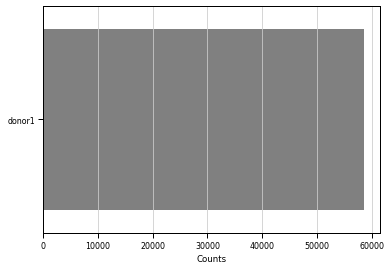

In [9]:
temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

#### Transcript capture efficiency

This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

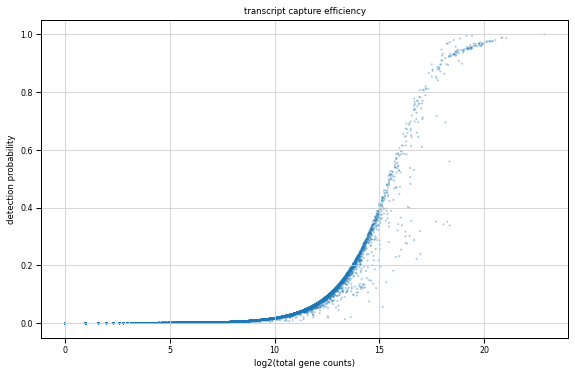

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Library size distribution

This plot gives you an idea about the library size distribution in your dataset before processing.

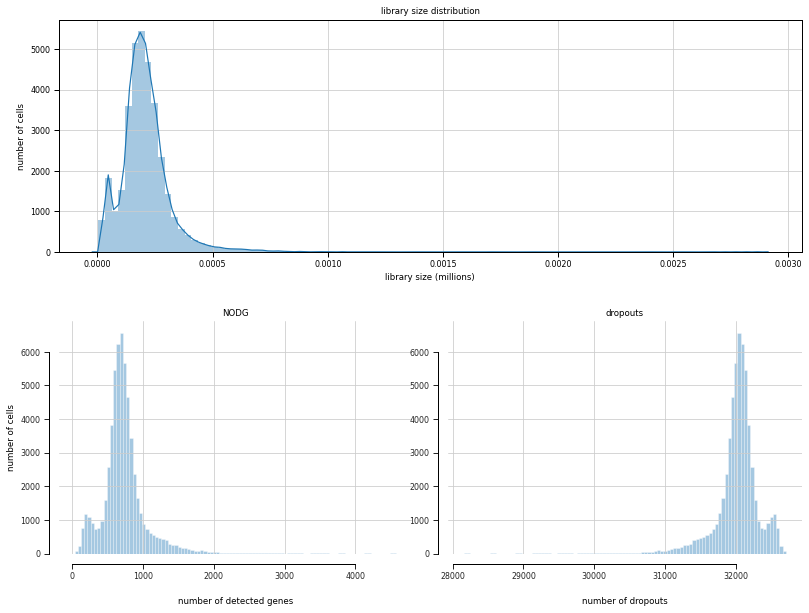

In [ ]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [ ]:
adata_unfiltered = adata.copy()

#### The effect of filtering parameters

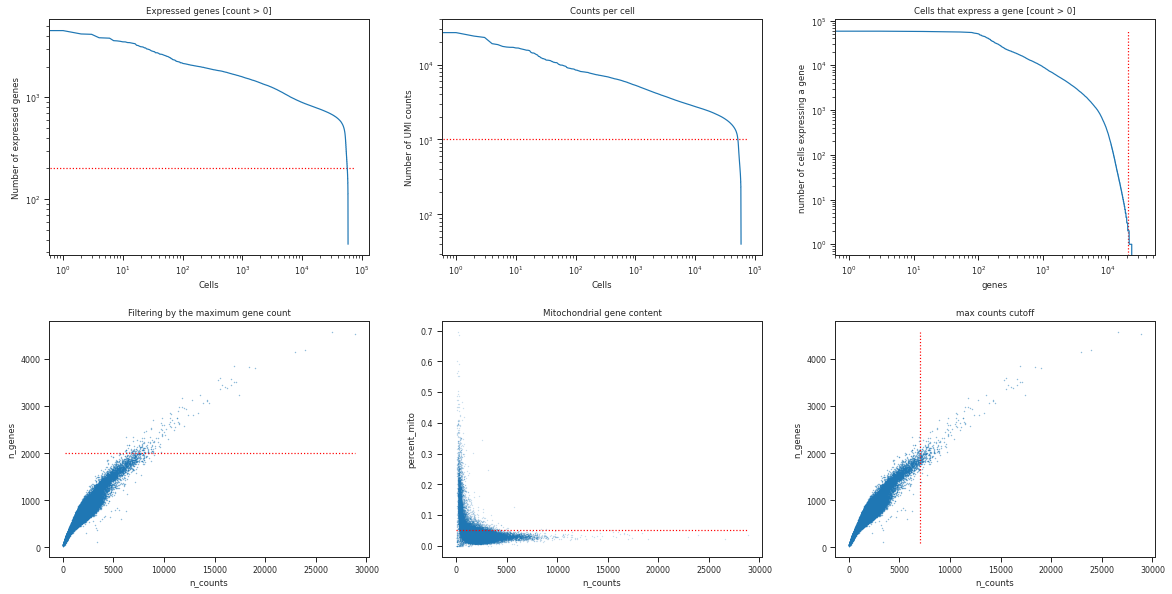

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Scanpy plots of genes, counts, and mitochondria gene counts

... storing 'donor' as categorical


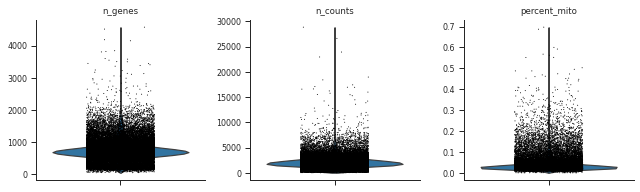

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.2, multi_panel=True, save = '.before_filtering.png')

#### Mitochondrial genes, genes, and counts by samples grouped by the split condition

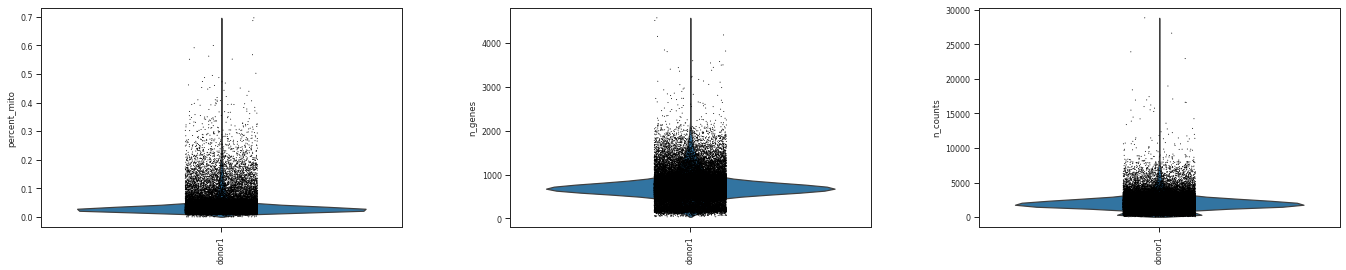

In [ ]:
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### Filtering

#### Filtering with thresholds of gene and cell counts

In [ ]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 51917 cells, 21535 genes
LOG MESSAGE: 	Time for filtering: 1.276s


In [ ]:
filtering1.show()

started with  58654  total cells and  32738  total genes
removed 1749 cells that did not express at least 200  genes
removed 4988 cells that did not have at least 1000 counts
removed 11203 genes that were not expressed in at least 2 cells
finished with 51917  total cells and 21535 total genes


#### Filtering with thresholds of proportion of mitochondrial genes and the upper limit of gene counts

In [ ]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 49033 cells, 21535 genes
LOG MESSAGE: 	Time for filtering: 0.668s


In [ ]:
filtering2.show()

started with  51917  total cells and  21535  total genes
removed 191 cells that expressed more than 2000 genes
removed 135 cells that had more than 7000  counts
removed  2558  cells that expressed  5.0 percent mitochondrial genes or more
finished with 49033  total cells and 21535 total genes


#### Visualising QC metrics of the filtered dataset

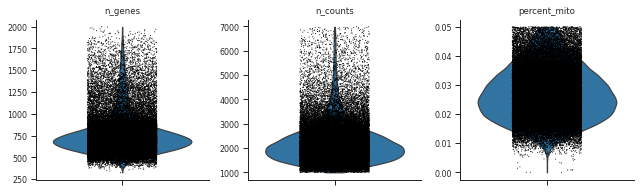

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.2, multi_panel=True, save = '.after_filtering.png')

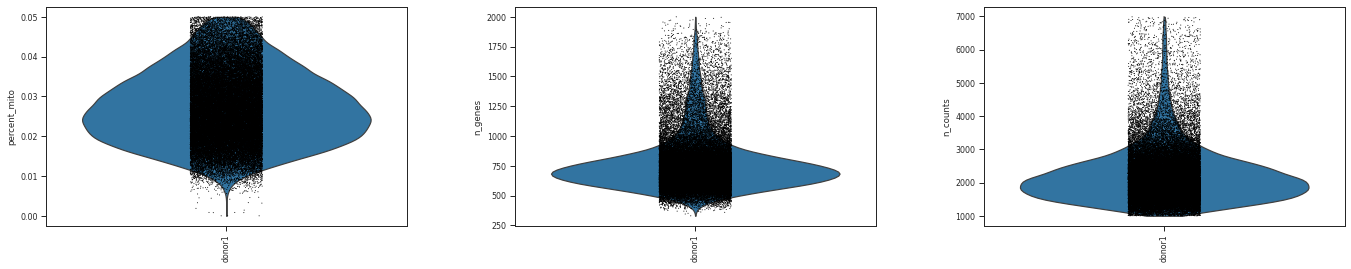

In [ ]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

<AxesSubplot:xlabel='Counts'>

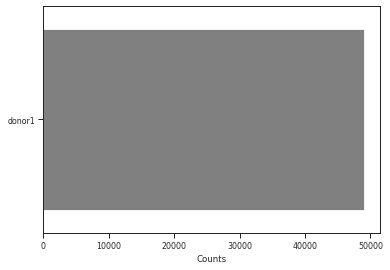

In [ ]:
### cell counts per sample
temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

In [ ]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

In [ ]:
adata.var

### Per-cell normalization and output of the normalized data

In [ ]:
adata = bc.st.per_cell_normalize(adata, results_folder)

We perform an additional QC, which checks the dynamic range of ubiquitously expressed marker genes.

In [ ]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')

### Feature selection (highly variable genes) for clustering ###

In [ ]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [ ]:
adata 

In [ ]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

### PCA-based neighborhood analysis and UMAP with optional batch correction

We use the Batch Balanced K-Nearest Neighbourhood (bbknn, [Teichlab/bbknn](https://github.com/Teichlab/bbknn)) method as the batch correction method.

In [ ]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering

In [ ]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [ ]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

In [ ]:
marker = [x for x in example_markers if x in adata.raw.var_names ] 
if len(marker) >0 :
    sc.pl.umap( adata, color = marker , color_map = 'viridis')

### Additional Labeling ###

If `labeling_to_use` is specified, additional labels are taken from annotations in "metadata.tsv", and the data associated with additional labelling will be exported to files. And the fract_pos.gct and average.gct files are generated.

In [ ]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

### CiteSeq Standard Wokflow (only executed if applicable)

In [ ]:
if citeseq:
    logging.info('Performing analysis of Citeseq Data.')
    sc.settings.figdir = os.path.join(results_folder_citeseq, 'figures') #update results directory
    start_citeseq = time.time()
    
    #apply filtering from gex to citeseq data
    cells = adata.obs_names.to_list()
    adata_prot = adata_prot[[x in cells for x in adata_prot.obs_names.tolist()], :]
    
    #generate a QC plot 
    n_prots = len(adata_prot.var_names)
    percent_top = (int(round(0.01*n_prots, 0)) if int(round(0.01*n_prots, 0)) >= 1 else 1, int(round(0.1*n_prots, 0)), int(round(0.25*n_prots, 0)))
    qc_adata = sc.pp.calculate_qc_metrics(adata_prot, percent_top=percent_top, var_type="antibodies", inplace=False)
    fig = sns.jointplot("log1p_total_counts", "n_antibodies_by_counts", qc_adata[0], kind="hex", norm=mpl.colors.LogNorm())
    fig.savefig(os.path.join(results_folder_citeseq,'figures', 'CITESEQ_QC_plot.png'))
    
    #generate overview of n_counts
    adata_prot.obs['n_counts'] = adata_prot.X.sum(axis=1)  
    
    #save counts into a layer
    adata_prot.layers["counts"] = adata_prot.X.copy()
    
    #perform normalization (this normalization is specific to CITEseq data)
    bc.st.clr_normalize(adata_prot, results_folder_citeseq)
    
    #no selection of highly variable genes since we want to use all measured proteins!
    #question if we should regress out?

    #perform batch correction if desired otherwise just perform clustering
    if (batch_to_correct != 'None'):
        #save a copy of uncorrected in case we need it for something later
        adata_prot_uncorrected = adata_prot.copy()
        adata_prot.obs['batch'] = adata_prot.obs[batch_to_correct]
        
        if n_prots < 50:
            nrpcs = n_prots - 1
        else:
            nrpcs = 50
        
        #important: nrpcs_neigh = 0, uses all input components not the calculated PCs
        adata_prot = bc.st.pca_neighbors_umap(adata_prot, results_folder_citeseq, method='bbknn', nrpcs = nrpcs, nrpcs_neigh=0)
    else:
        
        if n_prots < 50:
            nrpcs = n_prots - 1
        else:
            nrpcs = 50
        
        #important: nrpcs_neigh = 0, uses all input components not the calculated PCs
        adata_prot = bc.st.pca_neighbors_umap(adata_prot, results_folder_citeseq, nrpcs = nrpcs, nrpcs_neigh=0)
        
    #perform clustering
    adata_prot = bc.st.clustering(adata_prot, results_folder_citeseq)
    
    #save to file
    adata_prot.write(results_file_citeseq)
    logging.info('Citeseq analysis written to file: '+ results_file_citeseq)
    
    logging.info('Time for Citeseq analysis: '+str(round(time.time()-start_citeseq, 3))+'s')
    
    #generate a merged file which contains both the citeseq data and the gene expression data
    # (with clustering on gene expression data only)
    logging.info('Generating a merged adata object which contains both gene expression and citeseq data. Clustering and UMAP visualization were calculated using only the gene expression values as input.')
    sc.settings.figdir = os.path.join(results_folder_merged, 'figures') #update results directory
    start_merge = time.time()
    adata_merged = bc.concate_adata(adata, adata_prot)
    
    
    #add calculated values
    adata_merged.obsm['X_umap'] = adata.obsm['X_umap']
    adata_merged.obsm['X_pca'] = adata.obsm['X_pca']
    adata_merged.uns['neighbors'] = adata.uns['neighbors']
    
    #add leiden clustering of protein back in.
    adata_merged.obs['protein_leiden'] = adata_prot.obs["leiden"]
    
    #add protein calculated embedding
    adata_merged.obsm["protein"] = adata_prot.to_df()
    adata_merged.obsm["protein_umap"] = adata_prot.obsm["X_umap"]

    logging.info('Protein based embeddings were also saved into the object and can be plotted using sc.pl.embeddings')
    sc.pl.umap(adata_merged, color=["leiden", "protein_leiden"], size=10, save = '.rna_umap.clustering_results_rna_protein.png')
    sc.pl.embedding(adata_merged, basis="protein_umap", color=["leiden", "protein_leiden"], size=10, save = '.protein_umap.clustering_results_rna_protein.png')
    
    #save to file
    adata_merged.write(results_file_merged)
    logging.info('Merged Citeseq anndata object written to file: '+ results_file_merged)
    logging.info('Time for generation of merged anndata object: '+str(round(time.time()-start_merge, 3))+'s')

### Complete the log-file

In [ ]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

### Write QC Report

In [ ]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

### Session info

Finally, we report the session info with the package [sinfo](https://gitlab.com/joelostblom/sinfo).

In [ ]:
%%capture session_info
sinfo()

In [ ]:
logging.info(session_info)

### Convert to html

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')


In [ ]:
nb_name = os.path.join(os.getcwd(), nb_name)


In [ ]:
! jupyter nbconvert --to html {nb_name}